### Sensitivity of velocity magnitude at a point to a constant source/sink term flux under transient flow conditions

The sensitivity of velocity magnitude ($\lVert\bf{q}\rVert$) at a given point in space and time ($x',t'$) to the flux to/from a constant  source/sink term located at ($x_w$) under transient flow conditions in a one-dimensional plane can be calculated using an adjoint state-based approach as:
$$\begin{align}\cr
\frac{\partial \lVert\bf{q}(\it{x',t'})\rVert}{\partial Q_w(x_w)}=\int\limits_T\int\limits_X\psi^*(x,t)\;\delta(x-x_w)\;dx\;dt
\cr\cr\end{align}$$
This expression states that this sensitivity is equal to the spatio-temporal integral of the adjoint state variable at the source/sink term location only, as calculated by the adjoint state model.

### 1. Model setup

Here we define the model as a callable function, since it will be used by each of:
1. The forward model, featuring a 'base' set of parameter values;
2. A perturbed version of the forward model, featuring an infinitesimal increase in $Q_w$; and
3. The adjoint state model.

Each model is defined using the following six parameters:
1. Number of model columns ($ncol$)
2. Cell width along rows ($delr$)
3. Hydraulic conductivity ($K$)
4. Specific storage ($S_s$)
5. Hydraulic head specified on Dirichlet boundary ($h_{\Gamma_1}$) 
6. Volumetric flux specified at source/sink term location ($Q_w$) 

The variable $md$ is used to specify the working directory for each model.

Top and bottom of aquifer elevations are set to -100.0 and -101.0 metres respectively (resulting in an aquifer that is one metre thick) to ensure confined conditions.

Dirichlet boundary conditions are specified on the right-hand side of the model to represent outflows.

Initial conditions that are in equilibrium with specified boundary conditions and source/sink terms are calculated during a preceding steady state stress period. The variables $nsper$ and $ntper$ are used to specify the number of steady state and transient stress periods, all of which are one day in length.

Relatively tight convergence criteria values (i.e. 10$^{-6}$) are specified to ensure accuracy of perturbation-based sensitivities, which are based on differences between forward model outputs.

The velocity magnitude observation of interest is located at the midpoint of the model domain.

In [1]:
%matplotlib inline
import flopy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import flopy.utils.binaryfile as bf

def model(md, nrow, ncol, delr, nsper, ntper, K, Ss, BC1h, wcol, Qw):
    ml =  flopy.modflow.Modflow(modelname='model', model_ws=md)
    nrow = 1
    flopy.modflow.ModflowDis(ml, nlay=1, nrow=1, ncol=ncol, nper=nsper+ntper, delr=delr, delc=1., top=-100.0, 
                             botm=-101.0, steady=nsper*[True]+ntper*[False], perlen=(nsper+ntper)*[1.0], 
                             nstp=(nsper+ntper)*[1])
    ibound = np.ones([nrow, ncol], dtype=int)
    ibound[:, ncol-1] = -1 
    strt = BC1h*np.ones([nrow, ncol], dtype=float)
    flopy.modflow.ModflowBas(ml, ibound=ibound, strt=strt)
    flopy.modflow.ModflowLpf(ml, hk=K, vka=-999., ss=Ss, sy=-999., ipakcb=53)
    flopy.modflow.ModflowWel(ml, stress_period_data={0: [0, 0, wcol, Qw]}, ipakcb=53)
    flopy.modflow.ModflowPcg(ml, hclose=1e-6, rclose=1e-6)
    flopy.modflow.ModflowOc(ml, 
                            stress_period_data={(i,0): ['save head', 'save budget'] for i in range(nsper+ntper)})
    return ml

flopy is installed in C:\Python27\Lib\site-packages\flopy


Values for the 'base' parameter set are defined as follows. These can be modified to demonstrate the method for other model configurations.

In [2]:
nrow  = 1
ncol  = 7
ocol  = (ncol-1)/2
delr  = 1.0
nsper = 1
ntper = 3
K     = 0.2
Ss    = 1e-6
BC1h  = 1.0
wcol  = 1
Qw    = 1.0
dpar  = 1e-4

The model grid and boundary conditions can be presented visually as follows.

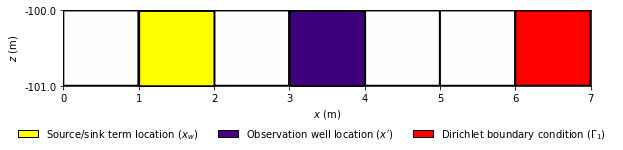

In [3]:
f,s = plt.subplots(1, 1, figsize=[24.00/2.54, 7.00/2.54])
s.set_aspect('equal')
grid = np.hstack([0.5*np.ones([1, ncol-1]), np.ones([1,1])])
s.pcolor(grid, edgecolors='k', linewidths=2, cmap='bwr', vmin=0.0, vmax=1.0)
grid[0, ocol] = 2.
s.pcolor(np.ma.masked_not_equal(grid, 2.), edgecolors='k', linewidths=2, cmap='Purples', vmin=0.0, vmax=2.0)
grid[0, ocol] = 0.
grid[0, wcol] = 2.
s.pcolor(np.ma.masked_not_equal(grid, 2.), edgecolors='k', linewidths=2, cmap='spring', vmin=0.0, vmax=2.0)
s.set_xlabel('$x$ (m)')
s.set_ylabel('$z$ (m)')
s.set_yticks([0., 1.])
s.set_yticklabels([-101., -100.])
l = f.legend(handles=[Patch(facecolor='yellow', edgecolor='k', label="Source/sink term location ($x_w$)"),
                      Patch(facecolor='indigo', edgecolor='k', label="Observation well location ($x'$)"),
                      Patch(facecolor='r', edgecolor='k', label='Dirichlet boundary condition ($\Gamma_1$)')], 
             fancybox=False, frameon=False, loc=8, ncol=4)

### 2. Sensitivity calculation using perturbation-based approach

First, the forward model featuring the 'base' parameter set is run.

In [4]:
md = 'forward_base'
ml = model(md, nrow, ncol, delr, nsper, ntper, K, Ss, BC1h, wcol, Qw)    

ml.write_input()
success, buff = ml.run_model(silent=True)

flx_base = np.reshape([bf.CellBudgetFile(md+'/'+'model.cbc').get_data(kstpkper=(0, kper), 
                                         text='FLOW RIGHT FACE') for kper in range(1, ntper+1)], [ntper, ncol])
qob_base = flx_base[-1, ocol]

The spatial distribution of velocity magnitude calculated by the 'base' forward model can be presented visually as follows.

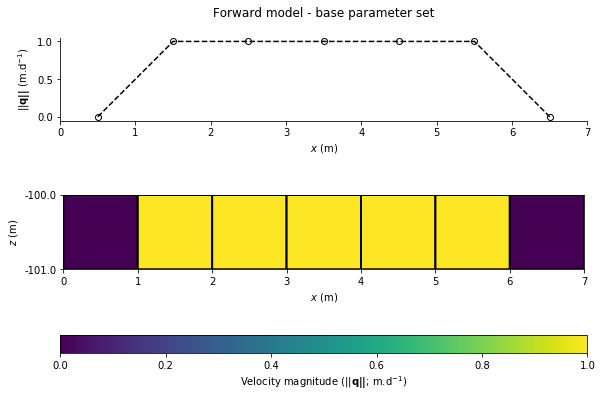

In [5]:
f,s = plt.subplots(2, 1, figsize=[24.00/2.54, 17.00/2.54])
s[0].set_aspect(1.0)
s[0].set_title('Forward model - base parameter set\n')
s[0].plot(0.5+np.arange(ncol), flx_base[-1,:].flatten(), 'ko--', mfc='none')
s[0].set_xlabel('$x$ (m)')
s[0].set_ylabel(r'$||\bf{q}||$ (m.d$^{-1}$)')
s[0].spines['top'].set_visible(False)            
s[0].spines['right'].set_visible(False)            
s[1].set_aspect('equal')
p = s[1].pcolor(np.atleast_2d(flx_base[-1,:]), edgecolors='k', linewidths=2, cmap='viridis')
s[1].set_xlabel('$x$ (m)')
s[1].set_ylabel('$z$ (m)')
s[1].set_yticks([0., 1.])
s[1].set_yticklabels([-101., -100.])
l = f.colorbar(p, orientation='horizontal', pad=0.4, aspect=30,
               label='Velocity magnitude ('+r'$||\bf{q}||$; m.d$^{-1}$)')
d = s[0].set_xlim(s[1].get_xlim())

Second, the forward model featuring the perturbed parameter set is run. 

In [6]:
md = 'forward_perturbed'
ml = model(md, nrow, ncol, delr, nsper, ntper, K, Ss, BC1h, wcol, Qw)    

ml.remove_package('wel')
flopy.modflow.ModflowWel(ml, stress_period_data={0: [0, 0, wcol, Qw*(1.0+dpar)]}, ipakcb=53)
ml.write_input()
success, buff = ml.run_model(silent=True)

flx_pert = np.reshape([bf.CellBudgetFile(md+'/'+'model.cbc').get_data(kstpkper=(0, kper), 
                                         text='FLOW RIGHT FACE') for kper in range(1, ntper+1)], [ntper, ncol])
qob_pert = flx_pert[-1, ocol]

The spatial distribution of velocity magnitude calculated by the perturbed forward model can be presented visually as follows.

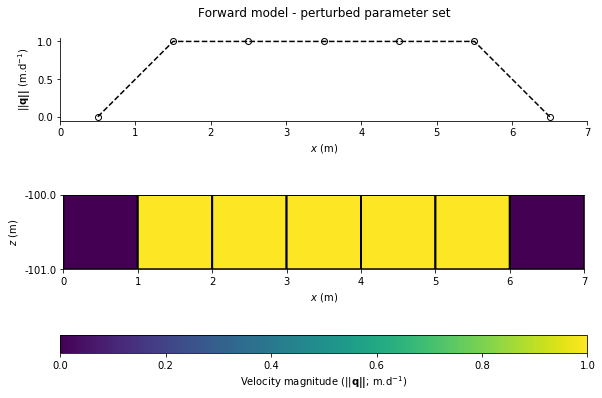

In [7]:
f,s = plt.subplots(2, 1, figsize=[24.00/2.54, 17.00/2.54])
s[0].set_aspect(1.0)
s[0].set_title('Forward model - perturbed parameter set\n')
s[0].plot(0.5+np.arange(ncol), flx_base[-1,:].flatten(), 'ko--', mfc='none')
s[0].set_xlabel('$x$ (m)')
s[0].set_ylabel(r'$||\bf{q}||$ (m.d$^{-1}$)')
s[0].spines['top'].set_visible(False)            
s[0].spines['right'].set_visible(False)            
s[1].set_aspect('equal')
p = s[1].pcolor(np.atleast_2d(flx_base[-1,:]), edgecolors='k', linewidths=2, cmap='viridis')
s[1].set_xlabel('$x$ (m)')
s[1].set_ylabel('$z$ (m)')
s[1].set_yticks([0., 1.])
s[1].set_yticklabels([-101., -100.])
l = f.colorbar(p, orientation='horizontal', pad=0.4, aspect=30,
               label='Velocity magnitude ('+r'$||\bf{q}||$; m.d$^{-1}$)')
d = s[0].set_xlim(s[1].get_xlim())

Third, the perturbation-based sensitivity is calculated.

In [8]:
dq_dQw_pert = (qob_pert-qob_base)/(Qw*dpar)

### 3. Sensitivity calculation using adjoint state-based approach

First, the adjoint state model is defined. This is mostly identical to the forward model, except for five conditions: 
1. The hydraulic head value specified on the Dirichlet boundary condition is set to zero.
2. The source/sink term used in the forward model is omitted. 
3. An impulse source of adjoint state is specified at the location of the hydraulic head observation of interest using an initial condition with a value equal to $K/delr$. The derivation of the adjoint sensitivity via the continuous approach assumed that the loading term was applied at a point in space. However, when using the finite difference numerical scheme used by MODFLOW, the loading term is distributed across the volume of a cell. For this reason, the loading term value (i.e. unity) was scaled (i.e. divided) by the cell volume. For this 1-D example, only scaling by cell width (i.e. $delr$) was required. The loading term was also scaled (i.e. divided) by uniform specific storage.
4. Zero-valued initial conditions are specified across the remainder of the model domain.
5. The steady state stress period used in the forward model to calculate equilibrium initial conditions is omitted.

In [9]:
md = 'adjoint'
nsper = 0
ml = model(md, nrow, ncol, delr, nsper, ntper, K, Ss, BC1h, wcol, Qw)    

ml.remove_package('bas6')
ibound = np.ones([nrow, ncol], dtype=int)
ibound[:, ncol-1] = -1
strt = np.zeros([nrow, ncol])
strt[0, ocol] = K/delr/3./delr/Ss
flopy.modflow.ModflowBas(ml, ibound=ibound, strt=strt)

ml.remove_package('wel')

ml.write_input()
success, buff = ml.run_model(silent=True)
adj = bf.HeadFile(md+'/'+'model.hds').get_alldata()

The adjoint state model grid and boundary conditions can be presented visually as follows.

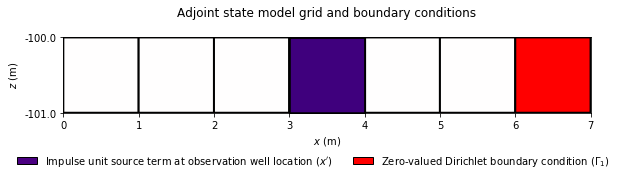

In [10]:
f,s = plt.subplots(1, 1, figsize=[24.00/2.54, 7.00/2.54])
s.set_aspect('equal')
s.set_title('Adjoint state model grid and boundary conditions\n')
grid = np.hstack([0.5*np.ones([1, ncol-1]), np.ones([1,1])])
s.pcolor(grid, edgecolors='k', linewidths=2, cmap='bwr', vmin=0.0, vmax=1.0)
grid[0, ocol] = 2.
s.pcolor(np.ma.masked_not_equal(grid, 2.), edgecolors='k', linewidths=2, cmap='Purples', vmin=0.0, vmax=2.0)
s.set_xlabel('$x$ (m)')
s.set_ylabel('$z$ (m)')
s.set_yticks([0., 1.])
s.set_yticklabels([-101., -100.])
l = f.legend(handles=[Patch(facecolor='indigo', edgecolor='k', 
                            label="Impulse unit source term at observation well location ($x'$)"),
                      Patch(facecolor='r', edgecolor='k', 
                            label='Zero-valued Dirichlet boundary condition ($\Gamma_1$)')], 
             fancybox=False, frameon=False, loc=8, ncol=3)

The spatial distribution of the adjoint state variable calculated by the adjoint model can be presented visually as follows. Note that the value of the adjoint state variable is zero at the right-most cell; this is because the Dirichlet boundary condition is zero-valued in the adjoint state model.

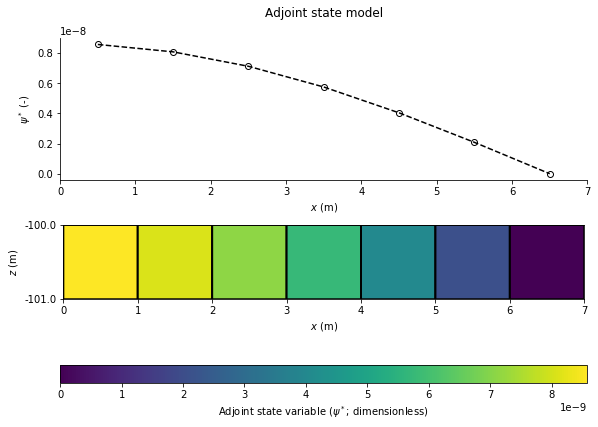

In [11]:
f,s = plt.subplots(2, 1, figsize=[24.00/2.54, 17.00/2.54])
s[0].set_aspect(2e8)
s[0].set_title('Adjoint state model\n')
s[0].plot(0.5+np.arange(ncol), adj[-1,0,:,:].flatten(), 'ko--', mfc='none')
s[0].set_xlabel('$x$ (m)')
s[0].set_ylabel('$\psi^*$ (-)')
s[0].spines['top'].set_visible(False)            
s[0].spines['right'].set_visible(False)            
s[1].set_aspect('equal')
p = s[1].pcolor(adj[-1,0,:,:], edgecolors='k', linewidths=2, cmap='viridis')
s[1].set_xlabel('$x$ (m)')
s[1].set_ylabel('$z$ (m)')
s[1].set_yticks([0., 1.])
s[1].set_yticklabels([-101., -100.])
l = f.colorbar(p, orientation='horizontal', pad=0.4, aspect=30, 
               label='Adjoint state variable ($\psi^*$; dimensionless)')
d = s[0].set_xlim(s[1].get_xlim())

Second, the adjoint state sensitivity is calculated. For this example [i.e. for the sensitivity $\partial \lVert\bf{q}(\it{x',t'})\rVert/\partial Q_w$], this is calculated using a combination of forward and adjoint model outputs, as described by the equation presented above.

In [12]:
dq_dQw_adj  = np.sum(adj[:, :, :, wcol])

### 4. Comparison of calculated sensitivities

In [13]:
print 'Perturbation-based sensitivity  = '+str('%14.6f'%  dq_dQw_pert)
print 'Adjoint state-based sensitivity = '+str('%14.6f'%  dq_dQw_adj)
print
print 'Ratio                           = '+str('%14.6e'% (dq_dQw_pert/dq_dQw_adj))
print 'Difference (absolute)           = '+str('%14.6e'% (dq_dQw_adj -dq_dQw_pert))
print 'Difference (percent)            = '+str('%14.6e'%  abs((dq_dQw_adj-dq_dQw_pert)/dq_dQw_pert))

Perturbation-based sensitivity  =       1.000166
Adjoint state-based sensitivity =       1.000000

Ratio                           =   1.000166e+00
Difference (absolute)           =  -1.661777e-04
Difference (percent)            =   1.661502e-04
